# 2022.8.19-8.20
- Background color change
- WM embedding with different background color
- Frequency wm embedding visualization & comparation


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def pltshow(img,gray=False):
    plt.figure(figsize=(5,5))
    plt.axis('off')
    if(gray):
        plt.imshow(img,cmap='gray')
    else:
        plt.imshow(img)

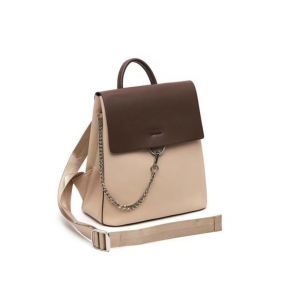

In [3]:
# load and show original image
img = cv2.imread('bag2.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
pltshow(img)

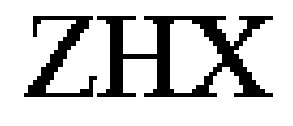

In [4]:
# load and show watermark image
wm = cv2.imread('zhx3.jpg',cv2.IMREAD_GRAYSCALE)
wm = np.where(wm<np.mean(wm),0,255)
pltshow(wm,gray=True)

In [5]:
def changebkcolor(img,low=np.array([5, 0, 0]),upper=np.array([255, 255, 220]),color=(255, 255, 0)):
    img_bk = img.copy()
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, low, upper)
    rows,cols = mask.shape
    for i in range(rows):
        for j in range(cols):
            if mask[i, j] == 0:  # 像素点255表示白色
                img_bk[i, j] = color
    return img_bk

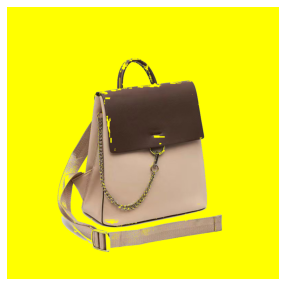

In [6]:
img_bk_yellow = changebkcolor(img)
pltshow(img_bk_yellow)

In [7]:
# watermark embedding parameters
alpha = 5
block_size = 4
k1 = np.random.randn(block_size)
k2 = np.random.randn(block_size)

In [8]:
# add border to image so that it can be divided perfectly with block_size
def addborder(img,block_size=4):
    diff_x = img.shape[0] % block_size
    diff_y = img.shape[1] % block_size
    if (diff_x==0 and diff_y==0):
        return img
    img = cv2.copyMakeBorder(img,
              0,(block_size-diff_x),
              0,(block_size-diff_y),
              cv2.BORDER_REPLICATE)
    return img

In [9]:
# tranform an image from original image to dct blocks
# param bk: a 2-dim numpy array
# param block_size: int
def dct_img(bk,block_size):
  img_dct_blocks_h = bk.shape[0] // block_size
  img_dct_blocks_w = bk.shape[1] // block_size
  img_dct_blocks = np.zeros(shape=(
      (img_dct_blocks_h,img_dct_blocks_w,block_size,block_size)
  ))
  h_data = np.vsplit(bk,img_dct_blocks_h)
  for h in range(img_dct_blocks_h):
    block_data = np.hsplit(h_data[h],img_dct_blocks_w)
    for w in range(img_dct_blocks_w):
        a_block = block_data[w]
        img_dct_blocks[h,w,...] = cv2.dct(a_block.astype(np.float64))
  return img_dct_blocks

In [10]:
# embed gray-scale watermrk into original RGB image
# param img: original image (3-dim RGB)
# param wm: watermark image (2-dim gray)
# param k1/k2: block-size 1-dim numpy array
# param alpha: embed strength
def embed_wm(img,wm,block_size,k1,k2,alpha,x=0,y=0):
  wm = np.where(wm<np.mean(wm),0,1)
  yuv_img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
  Y,U,V = yuv_img[...,0],yuv_img[...,1],yuv_img[...,2]
  bk = U
  img_dct_blocks = dct_img(bk,block_size)
  dct_embed_result = img_dct_blocks.copy()
  if (wm.shape[0]+x>img_dct_blocks.shape[0] or wm.shape[1]+y>img_dct_blocks.shape[1]):
    print('Illegal location')
    return None
  for h in range(x,wm.shape[0]+x):
      for w in range(y,wm.shape[1]+y):
          k = k1 if wm[h-x,w-y] == 1 else k2
          for i in range(block_size):
              dct_embed_result[h,w,i,block_size-1] = \
              img_dct_blocks[h,w,i,block_size-1] + alpha * k[i]
  row = None
  idct_result = None
  for h in range(dct_embed_result.shape[0]):
      for w in range(dct_embed_result.shape[1]):
          block = cv2.idct(dct_embed_result[h,w,...])
          row = block if w == 0 else np.hstack((row,block))
      idct_result = row if h == 0 else np.vstack((idct_result,row))
  img_embed_result_yuv = np.stack((Y,idct_result,V),axis=2).astype(np.uint8)
  img_embed_result_bgr = cv2.cvtColor(img_embed_result_yuv,cv2.COLOR_YUV2BGR)
  img_embed_result = cv2.cvtColor(img_embed_result_bgr,cv2.COLOR_BGR2RGB)
  return img_embed_result

In [11]:
def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
# correlation estimation
def corr2(a, b):
    a = a - mean2(a)
    b = b - mean2(b)
    r = (a * b).sum() / (np.sqrt((a * a).sum() * (b * b).sum())+1e-9)
    return r

In [12]:
# extract watermark from RGB wmed image
# param img: wmed RGB image
# param k1/k2: block-size 1-dim numpy array
# param wm_shape: 1-dim array [height,width] of watermark
# param block_size: int
def recover_wm(img,k1,k2,wm_shape,block_size,x=0,y=0):
  recover_wm = np.zeros(shape=wm.shape)
  yuv_img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
  Y,U,V = yuv_img[...,0],yuv_img[...,1],yuv_img[...,2]
  bk = U
  wmed_dct_result = dct_img(bk,block_size)
  p = np.zeros(block_size)
  for h in range(x,wm_shape[0]+x):
      for w in range(y,wm_shape[1]+y):
          for k in range(block_size):
              p[k] = wmed_dct_result[h,w,k,block_size-1]
          if corr2(p,k1) > corr2(p,k2):
              recover_wm[h-x,w-y] = corr2(p,k1)
          else:
              recover_wm[h-x,w-y] = 0
  return recover_wm

In [13]:
def show_origin_and_wmed(img,wm,block_size=4,k1 = np.random.randn(4),k2 = np.random.randn(4),alpha=5,x=0,y=0):
    img = addborder(img)
    wmed_img = embed_wm(img,wm,block_size,k1,k2,alpha,x,y)
    wm_extract = recover_wm(wmed_img,k1,k2,wm.shape,block_size,x,y)
    plt.figure(figsize=(20,20))
    plt.subplot(1,4,1)
    plt.imshow(img)
    plt.title('Original image')
    plt.axis('off')
    plt.subplot(1,4,2)
    plt.imshow(wmed_img)
    plt.title('With DCT watermark')
    plt.axis('off')
    plt.subplot(1,4,3)
    plt.imshow(wmed_img-img)
    plt.title('Difference')
    plt.axis('off')
    plt.subplot(1,4,4)
    plt.imshow(wm_extract,cmap='gray')
    plt.title('Extracted watermark')
    plt.axis('off')
    plt.show()

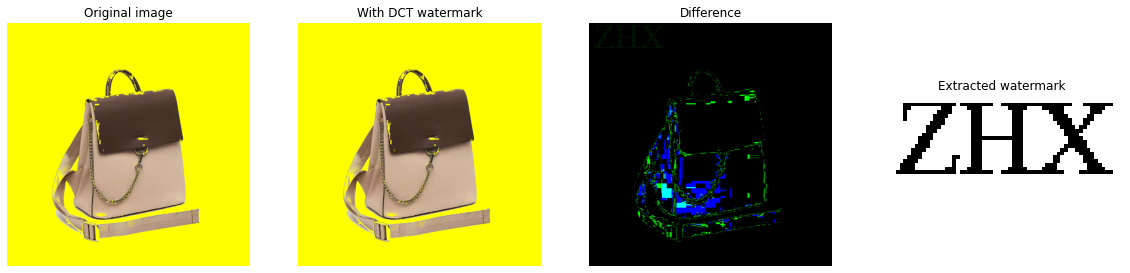

In [14]:
show_origin_and_wmed(img_bk_yellow,wm)

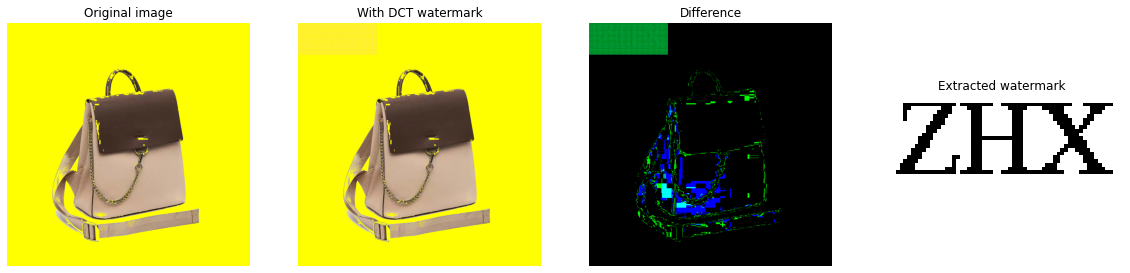

In [15]:
show_origin_and_wmed(img_bk_yellow,wm,alpha=50)

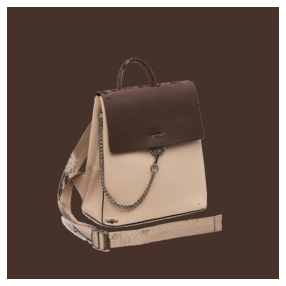

In [16]:
img_bk_brown = changebkcolor(img,color=(70, 50, 40))
pltshow(img_bk_brown)

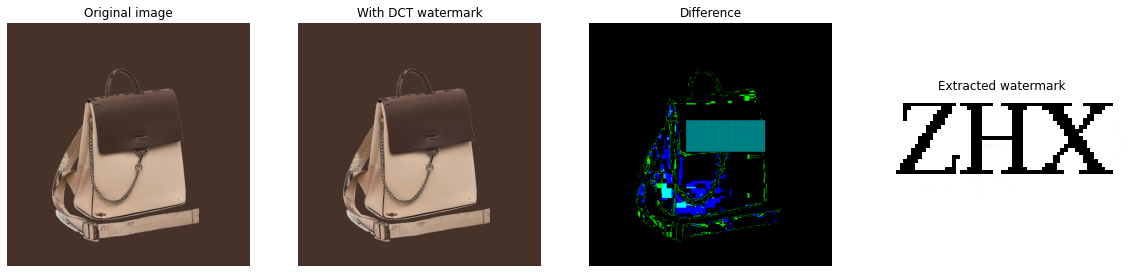

In [17]:
show_origin_and_wmed(img_bk_brown,wm,alpha=80,x=80,y=80)

In [18]:
arr = np.array([[[[0,1],[4,5]],[[2,3],[6,7]]],[[[8,9],[12,13]],[[10,11],[14,15]]]],dtype=int)

In [19]:
def recover_img_from_block(arr):
    x,y,b_x,b_y = arr.shape  
    arr_re = np.zeros([x*b_x,y*b_y])
    for a in range(x):
        for b in range(y):
            for c in range(b_x):
                for d in range(b_y):
                    arr_re[a*b_x+c,b*b_y+d]=arr[a,b,c,d]
    return arr_re

In [39]:
def dct_embed_visualize(img,wm,block_size=4,k1=np.random.randn(4),k2=np.random.randn(4),alpha=50,x=0,y=0):
    wm = np.where(wm<np.mean(wm),0,1)
    yuv_img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
    Y,U,V = yuv_img[...,0],yuv_img[...,1],yuv_img[...,2]
    bk = U
    img_dct_blocks = dct_img(bk,block_size)
    dct_embed_result = img_dct_blocks.copy()
    if (wm.shape[0]+x>img_dct_blocks.shape[0] or wm.shape[1]+y>img_dct_blocks.shape[1]):
        print('Illegal location')
        return None
    for h in range(x,wm.shape[0]+x):
        for w in range(y,wm.shape[1]+y):
            k = k1 if wm[h-x,w-y] == 1 else k2
            for i in range(block_size):
                dct_embed_result[h,w,i,block_size-1] = \
                img_dct_blocks[h,w,i,block_size-1] + alpha * k[i]
    img_dct = recover_img_from_block(img_dct_blocks)
    img_dct_wmed = recover_img_from_block(dct_embed_result)
    plt.figure(figsize=(20,20))
    plt.subplot(1,3,1)
    plt.imshow(img_dct,cmap='gray')
    plt.title('Original U')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(img_dct_wmed,cmap='gray')
    plt.title('With DCT watermark')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(img_dct_wmed-img_dct,cmap='gray')
    plt.title('Difference')
    plt.axis('off')
    plt.savefig('dct_visual08251236.jpg')
    plt.show()

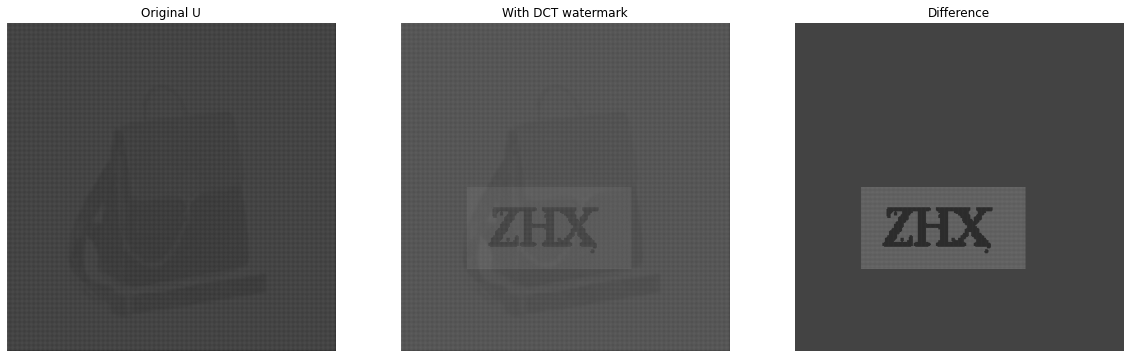

In [42]:
wm = cv2.imread('zhx2.jpg',cv2.IMREAD_GRAYSCALE)
wm = np.where(wm<np.mean(wm),0,255).astype('uint8')
wm_large = cv2.resize(wm,dsize=(200,100),fx=1,fy=1,interpolation=cv2.INTER_LINEAR)
dct_embed_visualize(img,wm_large,block_size=2,k1=np.random.randn(2),k2=np.random.randn(2),x=200,y=80)